In [ ]:
### Import packages 
import networkx as nx # for handling graphs/networks 
import numpy as np # for basic scientific computing 
import pandas as pd # for basic scientific computing 
import matplotlib.pyplot as plt # for plotting
import matplotlib.gridspec as gridspec

import seaborn as sns

from scipy.special import binom

from scipy.integrate import solve_ivp
import Koopman_source as kp
from math import comb
#from copy import copy
import csv

from scipy.special import expit


In [32]:
## Toy example from the Steven's note
# Discrete dynamical system

def toy_d1(t, x0, mu0, lambda0): # Here, d1 stands for the first discrete example.
    # t must be a positive integer.
    # x0 is the initial value x(0) = x0
    #mu0, lambda0 = kappa[0], kappa[1]
    x_mat = np.zeros([len(x0),t]) # matrix for saving trajectories. It does not save the initial value.
    x_old = x0.copy()
    x_new = x_old
    for i in range(t):
        x_new[0] = (1+mu0)*x_old[0]
        x_new[1] = (1+lambda0)*x_old[1]
        x_mat[:,i] = x_new
    return x_mat

def toy_d1_F(x_old, mu0, lambda0):
    x_new = x_old.copy()
    x_new[0] = (1+mu0)*x_old[0]
    x_new[1] = (1+lambda0)*x_old[1]
    return x_new

def toy_d2_F(x_old, mu0, lambda0):
    x_new = x_old.copy()
    x_new[0] = (1+mu0)*x_old[0]
    x_new[1] = (1+lambda0)*x_old[1] - lambda0 * np.power(x_old[0],2)
    return x_new

def toy_d2_Koopman(x_old, mu0, lambda0):
    x_new = x_old.copy()
    x_new[0] = (1+mu0)*x_old[0]
    x_new[1] = (1+lambda0)*x_old[1] - lambda0 * x_old[2]
    x_new[2] = np.power((1+mu0), 2)*x_old[2]
    return x_new

def toy_d3_F(x_old, mu0, lambda0, gamma0, k1, k2, k3, k4):
    x_new = x_old.copy()
    x_new[0] = (1+mu0)*x_old[0]
    x_new[1] = (1+lambda0)*x_old[1] + k1 * x_old[2] - k2 * np.power(x_old[0],2)
    x_new[2] = (1+gamma0)*x_old[2] + k3 * x_old[0] - k4 * np.power(x_old[0],2)
    return x_new

def toy_d3_Koopman(x_old, mu0, lambda0):
    x_new = x_old.copy()
    x_new[0] = (1+mu0)*x_old[0]
    x_new[1] = (1+lambda0)*x_old[1] + k1 * x_old[2] - k2 * x_old[3]
    x_new[2] = (1+gamma0)*x_old[2] + k3 * x_old[0] - k4 * x_old[3]
    x_new[3] = np.power((1+mu0), 2)*x_old[3]
    return x_new


def psi_id(x):
    return x
    
def psi_d1(x):
    return x

def psi_d2(x):
    d = 2 # the number of variables or the dimension of a dynamical system.
    max_order = 2
    num_obs = comb(max_order+d, d)# (d+max_order)Cd = dH0 + dH1 + \cdots dHmax_order by the hockey stick rule where H is repeated combination nHr = (n+r-1)Cr
    obs = np.zeros(num_obs) # the total number of observable functions, psi_m's.
    idx = 0 
    for i in range(max_order+1):
        for j in range(i+1):
            obs[idx] = np.power(x[0], i-j) * np.power(x[1], j)
            idx += 1
    return obs

def Laguerre_poly(x, n):
    if n==0:
        return 1
    if n==1:
        return -x+1
    if n>1:
        return ((2*n-1-x)*Laguerre_poly(x, n-1) - (n-1)*Laguerre_poly(x, n-2))/n


def psi_d2_Laguerre(x):
    d = 2 # the number of variables or the dimension of a dynamical system.
    max_order = 3
    num_obs = comb(max_order+d, d)# (d+max_order)Cd = dH0 + dH1 + \cdots dHmax_order by the hockey stick rule where H is repeated combination nHr = (n+r-1)Cr
    obs = np.zeros(num_obs) # the total number of observable functions, psi_m's.
    idx = 0 
    for i in range(max_order+1):
        for j in range(i+1):
            obs[idx] = Laguerre_poly(x[0], i-j) * Laguerre_poly(x[1], j)
            idx += 1
    return obs


def psi_d3(x):
    d = 3 # the number of variables or the dimension of a dynamical system.
    max_order = 3
    num_obs = comb(max_order+d, d)# (d+max_order)Cd = dH0 + dH1 + \cdots dHmax_order by the hockey stick rule where H is repeated combination nHr = (n+r-1)Cr
    obs = np.zeros(num_obs) # the total number of observable functions, psi_m's.

    obs = np.zeros(19) # 20 = the total number of observable functions, psi_m's.
    idx = 0 
    for i in range(max_order+1):
        for j in range(i+1):
            for k in range(i-j+1):
                obs[idx] = np.power(x[0], i-j-k) * np.power(x[1], k) * np.power(x[2], j)
                idx += 1
                #print(i-j-k, k, j)
    return obs


def psi_d2_ans(x):
    obs = np.zeros(3) # = the total number of observable functions, psi_m's.
    obs[0] = x[0]
    obs[1] = x[1]
    obs[2] = np.power(x[0],2)
    return obs
            

### ====== Page-Rank Algorithm ======================
def pagerank(M, num_iterations=100, d=0.85):
    N = M.shape[0]
    
    # Initialize the PageRank vector
    v = np.ones(N) / N
    
    # Compute the column sum
    out_degree = np.sum(M, axis=0)
    
    # Normalize the adjacency matrix
    M_hat = M / out_degree
    
    # PageRank iteration
    for _ in range(num_iterations):
        v_next = (1 - d) / N + d * M_hat.dot(v)
        if np.allclose(v, v_next):
            return v_next
        v = v_next
    
    return v

def subsampled_pagerank(M, num_iterations=100, d=0.85, subsample_rate=0.1, epsilon=1e-8):
    N = M.shape[0]
    
    # Normalize the adjacency matrix
    M_hat = M / np.sum(M, axis=0)
    
    # Initialize the PageRank vector
    v = np.ones(N) / N
    
    for _ in range(num_iterations):
        v_prev = v.copy()
        
        # Subsampling
        mask = np.random.random(N) < subsample_rate
        subsampled_M = M_hat[:, mask]
        subsampled_v = v_prev[mask]
        
        # PageRank update
        v = (1 - d) / N + d * subsampled_M.dot(subsampled_v / subsample_rate)
        
        # Check for convergence
        if np.sum(np.abs(v - v_prev)) < epsilon:
            break
    
    return v / np.sum(v)


In [33]:
np.random.seed(123)

## Compute a Koopman matrix from simulated data.
mu0 = -0.1
lambda0 = -0.2
gamma0 = -0.15
k1 = 0.1
k2 = 0.2
k3 = 0.1
k4 = 0.15

K_true = np.array([[1+mu0, 0, 0], [0, 1+lambda0, -lambda0], [0, 0, (1+mu0)**2]])
G_inv_true = np.array([[11/4, -3/4, -5/8], [-3/4, 3/4, 1/8], [-5/8, 1/8, 3/16]])
G_true = np.array([[2,1,6],[1,2,2,],[6,2,24]])
np.matmul(G_inv_true, G_true)
A_true = np.matmul(G_true, np.transpose(K_true))

#x0 = [2,1]

model = "d2"
sequential = False

if model == "d2_ans":
    d = 2
elif model == "d2":
    d = 2 # the number of variables (=the dimension) of the original dynamical system.
elif model == "d3":
    d = 3
#M = 100 # the number of observed data. 

orth_basis = True

M_max = 200 # the maximum number of observed data. 
n_repeat = 2 # the number of repetition of approximaing the Koopman matrix. 
max_order = 3
N = comb(d+max_order,d) # the total number of observable functions, psi_m's. 
N1 = 4
N2 = N - N1

In [34]:
K_approx_accum = np.zeros([N,N,M_max,n_repeat])
G_approx_accum = np.zeros([N,N,M_max,n_repeat])
G_pinv_accum = np.zeros([N,N,M_max,n_repeat])
A_approx_accum = np.zeros([N,N,M_max,n_repeat])
Psi_X1_accum = np.zeros([M_max,N1,n_repeat]) 
Psi_Y2_accum = np.zeros([M_max,N2,n_repeat])
P_accum = np.zeros([M_max,M_max,M_max,n_repeat])
Psi_X1_P_Psi_X1_inv_accum = np.zeros([N1,N1,M_max,n_repeat])
Psi_X1_P_Psi_Y2_accum = np.zeros([N1,N2,M_max,n_repeat])
K12_accum = np.zeros([N1,N2,M_max,n_repeat])


for rr in range(n_repeat):
    if np.mod(rr, 20) == 0:
        print(rr)
    x_mat_total = np.random.default_rng().exponential(scale=1, size=[d,M_max])
    y_mat_total = np.zeros([d,M_max])

    K_approx = np.zeros([N,N,M_max])
    G_approx = np.zeros([N,N,M_max])
    G_pinv = np.zeros([N,N,M_max])
    A_approx = np.zeros([N,N,M_max])

    for i in range(M_max):
        if sequential == True:
            if model == "d2_ans":
                y_mat_total[:,i] = toy_d2_F(x_mat_total[:,i], mu0, lambda0)
                if i+1 < M_max:
                    x_mat_total[:,i+1] = y_mat_total[:,i]
            elif model == "d2":
                y_mat_total[:,i] = toy_d2_F(x_mat_total[:,i], mu0, lambda0)
                if i+1 < M_max:
                    x_mat_total[:,i+1] = y_mat_total[:,i]
            elif model == "d3":
                y_mat_total[:,i] = toy_d3_F(x_mat_total[:,i], mu0, lambda0, gamma0, k1, k2, k3, k4)
                if i+1 < M_max:
                    x_mat_total[:,i+1] = y_mat_total[:,i]
        else:
            if model == "d2_ans":
                y_mat_total[:,i] = toy_d2_F(x_mat_total[:,i], mu0, lambda0)
            elif model == "d2":
                y_mat_total[:,i] = toy_d2_F(x_mat_total[:,i], mu0, lambda0)
            elif model == "d3":
                y_mat_total[:,i] = toy_d3_F(x_mat_total[:,i], mu0, lambda0, gamma0, k1, k2, k3, k4)

    Psi_X = np.zeros([M_max,N])
    Psi_Y = np.zeros([M_max,N])

    for i in range(M_max):
        if model == "d2_ans":
                Psi_X[i,:] = psi_d2_ans(x_mat_total[:,i])
                Psi_Y[i,:] = psi_d2_ans(y_mat_total[:,i])
        elif model == "d2":
            if orth_basis:
                Psi_X[i,:] = psi_d2_Laguerre(x_mat_total[:,i])
                Psi_Y[i,:] = psi_d2_Laguerre(y_mat_total[:,i])
            else:
                Psi_X[i,:] = psi_d2(x_mat_total[:,i])
                Psi_Y[i,:] = psi_d2(y_mat_total[:,i])
        elif model == "d3":
            Psi_X[i,:] = psi_d3(x_mat_total[:,i])
            Psi_Y[i,:] = psi_d3(y_mat_total[:,i])

    Psi_X1 = Psi_X[np.ix_(range(M_max),range(N1))]
    Psi_X2 = Psi_X[np.ix_(range(M_max),range(N1, N))]
    Psi_Y1 = Psi_Y[np.ix_(range(M_max),range(N1))]
    Psi_Y2 = Psi_Y[np.ix_(range(M_max),range(N1, N))]
    Psi_X1_accum[:,:,rr] = Psi_X1
    Psi_Y2_accum[:,:,rr] = Psi_Y2
    
    # for M in range(1, M_max+1):
    #     #A = np.matmul(Psi_X1[np.ix_(range(M),range(N1))].transpose(), Psi_X1[np.ix_(range(M),range(N1))])
    #     #B = np.matmul(Psi_X1[np.ix_(range(M),range(N1))].transpose(), Psi_X2[np.ix_(range(M),range(N2))])
    #     #C = np.matmul(Psi_X2[np.ix_(range(M),range(N2))].transpose(), Psi_X1[np.ix_(range(M),range(N1))])
    #     D = np.matmul(Psi_X2[np.ix_(range(M),range(N2))].transpose(), Psi_X2[np.ix_(range(M),range(N2))])
    #     P = np.identity(M) - np.linalg.multi_dot([Psi_X2[np.ix_(range(M),range(N2))], np.linalg.pinv(D), Psi_X2[np.ix_(range(M),range(N2))].transpose()])
    #     #Q = np.linalg.multi_dot([Psi_X1[np.ix_(range(M),range(N1))].transpose(), np.linalg.pinv(P), Psi_X1[np.ix_(range(M),range(N1))]])
    #     P_accum[np.ix_(range(M),range(M),[M-1],[rr])] = P.reshape((M,M,1,1))
    
    #     Psi_X1_P_Psi_X1_inv_accum[:,:,M-1,rr] = np.linalg.pinv(np.linalg.multi_dot([Psi_X1[np.ix_(range(M),range(N1))].transpose(), P, Psi_X1[np.ix_(range(M),range(N1))]]))
    #     Psi_X1_P_Psi_Y2_accum[:,:,M-1,rr] = np.linalg.multi_dot([Psi_X1[np.ix_(range(M),range(N1))].transpose(), P, Psi_Y2[np.ix_(range(M),range(N2))]])
    #     K12_accum[:,:,M-1,rr] = np.matmul(Psi_X1_P_Psi_X1_inv_accum[:,:,M-1,rr], Psi_X1_P_Psi_Y2_accum[:,:,M-1,rr])

    G_approx[:,:,0] = np.matmul(Psi_X[np.ix_(range(1),range(N))].transpose(), Psi_X[np.ix_(range(1),range(N))])
    G_pinv[:,:,0] = np.linalg.pinv(G_approx[:,:,0])
    A_approx[:,:,0] = np.matmul(Psi_X[np.ix_(range(1),range(N))].transpose(), Psi_Y[np.ix_(range(1),range(N))])
    K_approx[:,:,0] = np.matmul(G_pinv[:,:,0], A_approx[:,:,0])

    for M in range(2,M_max+1):  
        G_approx[:,:,M-1] = G_approx[:,:,M-2] + np.matmul(Psi_X[np.ix_(range(M-1,M),range(N))].transpose(), Psi_X[np.ix_(range(M-1,M),range(N))])
        G_pinv[:,:,M-1] = np.linalg.pinv(G_approx[:,:,M-1])
        A_approx[:,:,M-1] = A_approx[:,:,M-2] + np.matmul(Psi_X[np.ix_(range(M-1,M),range(N))].transpose(), Psi_Y[np.ix_(range(M-1,M),range(N))])
        K_approx[:,:,M-1] = np.matmul(G_pinv[:,:,M-1], A_approx[:,:,M-1])

    G_approx_accum[:,:,:,rr] = G_approx
    G_pinv_accum[:,:,:,rr] = G_pinv
    A_approx_accum[:,:,:,rr] = A_approx
    K_approx_accum[:,:,:,rr] = K_approx

0


In [35]:
mean_mat_K_approx = np.zeros([N,N,M_max])
var_mat_K_approx = np.zeros([N,N,M_max])
mean_mat_G_approx = np.zeros([N,N,M_max])
var_mat_G_approx = np.zeros([N,N,M_max])
mean_mat_G_pinv = np.zeros([N,N,M_max])
var_mat_G_pinv = np.zeros([N,N,M_max])
mean_mat_A_approx = np.zeros([N,N,M_max])
var_mat_A_approx = np.zeros([N,N,M_max])
mean_mat_PX1_P_PX1_inv = np.zeros([N1,N1,M_max])
var_mat_PX1_P_PX1_inv = np.zeros([N1,N1,M_max])
mean_mat_PX1_P_PY2 = np.zeros([N1,N2,M_max])
var_mat_PX1_P_PY2 = np.zeros([N1,N2,M_max])
mean_mat_K12_approx = np.zeros([N1,N2,M_max])
var_mat_K12_approx = np.zeros([N1,N2,M_max])
mean_mat_P_PX1 = np.zeros([M_max,N1,M_max])
var_mat_P_PX1 = np.zeros([M_max,N1,M_max])
mean_mat_P_PY2 = np.zeros([M_max,N2,M_max])
var_mat_P_PY2 = np.zeros([M_max,N2,M_max])
mean_mat_PX1_PY2 = np.zeros([N1,N2,M_max])
var_mat_PX1_PY2 = np.zeros([N1,N2,M_max])
mean_mat_PX1_PX1 = np.zeros([N1,N1,M_max])
var_mat_PX1_PX1 = np.zeros([N1,N1,M_max])

norm_mean_mat_PX1_PX1 = np.zeros([N1,N1,M_max])
norm_var_mat_PX1_PX1 = np.zeros([N1,N1,M_max])
norm_mean_mat_PX1_PY2 = np.zeros([N1,N2,M_max])
norm_var_mat_PX1_PY2 = np.zeros([N1,N2,M_max])

var_mat = np.zeros([N,N,M_max])
mean_mat = np.zeros([N,N,M_max])

num_avg = n_repeat
for ii in range(N):
    for jj in range(N):
        for mm in range(M_max):
            mean_mat_K_approx[ii,jj,mm] = np.mean(K_approx_accum[ii,jj,mm,range(num_avg)])
            var_mat_K_approx[ii,jj,mm] = np.var(K_approx_accum[ii,jj,mm,range(num_avg)])

            mean_mat_G_approx[ii,jj,mm] = np.mean(G_approx_accum[ii,jj,mm,range(num_avg)])
            var_mat_G_approx[ii,jj,mm] = np.var(G_approx_accum[ii,jj,mm,range(num_avg)])

            mean_mat_G_pinv[ii,jj,mm] = np.mean(G_pinv_accum[ii,jj,mm,range(num_avg)])
            var_mat_G_pinv[ii,jj,mm] = np.var(G_pinv_accum[ii,jj,mm,range(num_avg)])

            mean_mat_A_approx[ii,jj,mm] = np.mean(A_approx_accum[ii,jj,mm,range(num_avg)])
            var_mat_A_approx[ii,jj,mm] = np.var(A_approx_accum[ii,jj,mm,range(num_avg)])

Psi_X1_Psi_X1_accum = np.empty([N1,N1,M_max,n_repeat])
Psi_X1_Psi_Y2_accum = np.empty([N1,N2,M_max,n_repeat])
for rr in range(n_repeat):
    for M in range(1, M_max+1):
        Psi_X1_Psi_X1_accum[:,:,M-1,rr] = np.matmul(Psi_X1_accum[range(M),:,rr].transpose(), Psi_X1_accum[range(M),:,rr])
        Psi_X1_Psi_Y2_accum[:,:,M-1,rr] = np.matmul(Psi_X1_accum[range(M),:,rr].transpose(), Psi_Y2_accum[range(M),:,rr])
    
for ii in range(N1):
    for jj in range(N1):
        for mm in range(M_max):
            # mean_mat_PX1_P_PX1_inv[ii,jj,mm] = np.mean(Psi_X1_P_Psi_X1_inv_accum[ii,jj,mm,range(num_avg)])
            # var_mat_PX1_P_PX1_inv[ii,jj,mm] = np.var(Psi_X1_P_Psi_X1_inv_accum[ii,jj,mm,range(num_avg)])
            
            mean_mat_PX1_PX1[ii,jj,mm] = np.mean(Psi_X1_Psi_X1_accum[ii,jj,mm,range(num_avg)])
            var_mat_PX1_PX1[ii,jj,mm] = np.var(Psi_X1_Psi_X1_accum[ii,jj,mm,range(num_avg)])
            
            norm_mean_mat_PX1_PX1[ii,jj,mm] = np.mean(Psi_X1_Psi_X1_accum[ii,jj,mm,range(num_avg)]/(mm+1))
            norm_var_mat_PX1_PX1[ii,jj,mm] = np.var(Psi_X1_Psi_X1_accum[ii,jj,mm,range(num_avg)]/(mm+1))

    for jj in range(N2):
        for mm in range(M_max):
            # mean_mat_PX1_P_PY2[ii,jj,mm] = np.mean(Psi_X1_P_Psi_Y2_accum[ii,jj,mm,range(num_avg)])
            # var_mat_PX1_P_PY2[ii,jj,mm] = np.var(Psi_X1_P_Psi_Y2_accum[ii,jj,mm,range(num_avg)])
            # mean_mat_K12_approx[ii,jj,mm] = np.mean(K12_accum[ii,jj,mm,range(num_avg)])
            # var_mat_K12_approx[ii,jj,mm] = np.var(K12_accum[ii,jj,mm,range(num_avg)])
            mean_mat_PX1_PY2[ii,jj,mm] = np.mean(Psi_X1_Psi_Y2_accum[ii,jj,mm,range(num_avg)])
            var_mat_PX1_PY2[ii,jj,mm] = np.var(Psi_X1_Psi_Y2_accum[ii,jj,mm,range(num_avg)])
            
            norm_mean_mat_PX1_PY2[ii,jj,mm] =  np.mean(Psi_X1_Psi_Y2_accum[ii,jj,mm,range(num_avg)]/(mm+1))
            norm_var_mat_PX1_PY2[ii,jj,mm] = np.var(Psi_X1_Psi_Y2_accum[ii,jj,mm,range(num_avg)]/(mm+1))

# P_Psi_X1_accum = np.empty([M_max,N1,M_max,n_repeat])
# P_Psi_Y2_accum = np.empty([M_max,N2,M_max,n_repeat])
# P_Psi_X1_accum[:] = np.nan
# P_Psi_Y2_accum[:] = np.nan

# for rr in range(n_repeat):
#     print(rr)
#     for M in range(1, M_max+1):
#         P_Psi_X1_accum[np.ix_(range(M), range(N1), [M-1], [rr])] = np.matmul(np.squeeze(P_accum[np.ix_(range(M), range(M), [M-1], [rr])], axis = (2,3)), np.squeeze(Psi_X1_accum[np.ix_(range(M), range(N1), [rr])], axis = 2)).reshape((M,N1,1,1))
#         P_Psi_Y2_accum[np.ix_(range(M), range(N2), [M-1], [rr])] = np.matmul(np.squeeze(P_accum[np.ix_(range(M), range(M), [M-1], [rr])], axis = (2,3)), np.squeeze(Psi_Y2_accum[np.ix_(range(M), range(N2), [rr])], axis = 2)).reshape((M,N2,1,1))


# for mm1 in range(M_max):
#     for mm2 in range(mm1+1):
#         for ii in range(N1):
#             mean_mat_P_PX1[mm2,ii,mm1] = np.nanmean(P_Psi_X1_accum[mm2,ii,mm1,range(num_avg)])
#             var_mat_P_PX1[mm2,ii,mm1] = np.nanvar(P_Psi_X1_accum[mm2,ii,mm1,range(num_avg)])

#         for ii in range(N2):
#             mean_mat_P_PY2[mm2,ii,mm1] = np.nanmean(P_Psi_Y2_accum[mm2,ii,mm1,range(num_avg)])
#             var_mat_P_PY2[mm2,ii,mm1] = np.nanvar(P_Psi_Y2_accum[mm2,ii,mm1,range(num_avg)])

In [36]:
print(mean_mat_PX1_P_PX1_inv)
print(mean_mat_PX1_P_PY2)
print(mean_mat_K12_approx)
print(var_mat_PX1_P_PX1_inv)
print(var_mat_PX1_P_PY2)
print(var_mat_K12_approx)


[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.

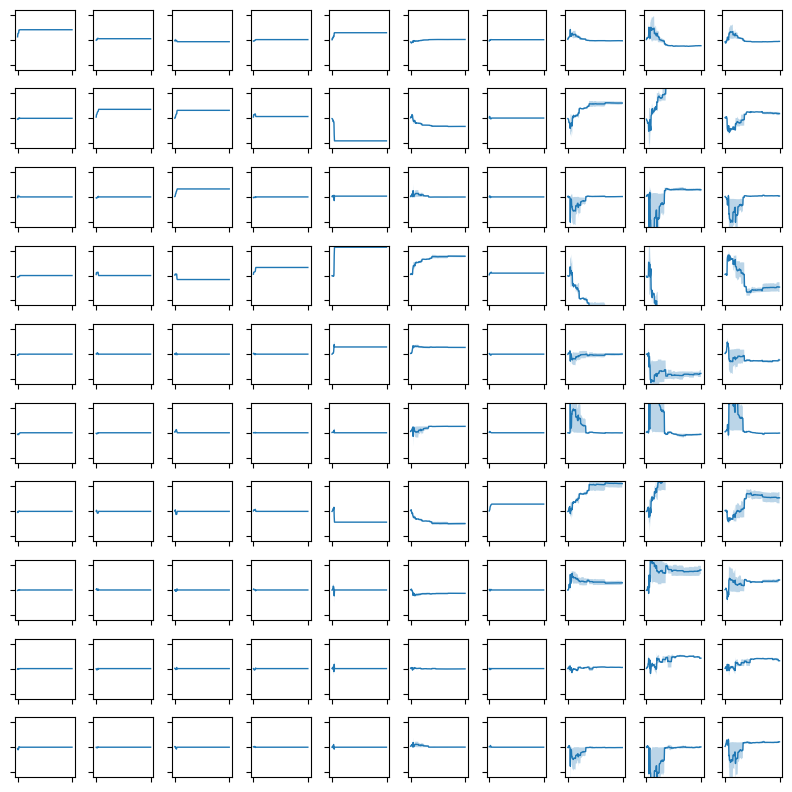

In [37]:
# Draw the evolution of each entry in the Koopman matrix approximated with increasing number of data from 1 to M_max.
iter_range = range(M_max)
ylim0 = [-3, 3]

mean_plot = mean_mat_K_approx
var_plot = var_mat_K_approx

i_list = range(mean_plot.shape[0])
#i_list = [0,1,49,50,98,99]
j_list = range(mean_plot.shape[1])


fig2, ax2 = plt.subplots(len(i_list), len(j_list), figsize = (8,8))
for ic in range(len(i_list)):
    for jc in range(len(j_list)):
        i = i_list[ic]
        j = j_list[jc]
        ax2[ic,jc].plot(iter_range, mean_plot[i,j,iter_range], linewidth = 1)
        ax2[ic,jc].fill_between(iter_range,  mean_plot[i,j,iter_range] - np.sqrt(var_plot[i,j,iter_range]), mean_plot[i,j,iter_range] + np.sqrt(var_plot[i,j,iter_range]), alpha = 0.3)
        # ax2[ic,jc].fill_between(iter_range,  mean_plot[i,j,iter_range] - var_plot[i,j,iter_range], mean_plot[i,j,iter_range] + var_plot[i,j,iter_range], alpha = 0.3)
        ax2[ic,jc].set_ylim(ylim0)
        ax2[ic,jc].set_xticklabels('')
        ax2[ic,jc].set_yticklabels('')

fig2.tight_layout(pad=1.0)
# plt.savefig('K_approx_diff.png')

In [38]:
eig_v = pagerank(abs(K_approx[:,:,M_max-1]), 5000, 0.85)
eig_v2 = subsampled_pagerank(abs(K_approx[:,:,M_max-1]), 5000, 0.85, 0.2)
# eig_v3 = pagerank(abs(data_test_2), 5000, 0.85)
ranked_idx = np.argsort(eig_v)[::-1]
ranked_idx2 = np.argsort(eig_v2)[::-1]
# ranked_idx3 = np.argsort(eig_v3)[::-1]

mixed_idx = np.random.permutation(N)

data = K_approx[:,:,M_max-1]
data_mx = K_approx[np.ix_(mixed_idx,mixed_idx, [M_max-1])]
data_pr = K_approx[np.ix_(ranked_idx,ranked_idx, [M_max-1])]
data_subpr = K_approx[np.ix_(ranked_idx2,ranked_idx2, [M_max-1])]
data = np.squeeze(data)
data_mx = np.squeeze(data_mx)
data_pr = np.squeeze(data_pr)
data_subpr = np.squeeze(data_subpr)
# Create a heatmap
#fig2, ax2 = plt.subplots(len(i_list), len(j_list), figsize = (8,8))
fig1, ax1 = plt.subplots(1,2,figsize = (12,4))
#plt.figure(figsize=(8, 6))
sns.heatmap(expit(data_mx*10), ax=ax1[0], annot=True, cmap='coolwarm', cbar=True)
sns.heatmap(expit(data_pr*10), ax=ax1[1], annot=True, cmap='coolwarm', cbar=True)
# sns.heatmap(expit(data_subpr*10), ax=ax1[2], annot=True, cmap='coolwarm', cbar=True)
# sns.heatmap(expit(data*100), annot=True, cmap='coolwarm', cbar=True)
# sns.heatmap(1/(1+np.exp(-data)), annot=True, cmap='coolwarm', cbar=True)

# Add title and labels
plt.title("Heatmap Example")
plt.xlabel("Columns")
plt.ylabel("Rows")


IndexError: index 18 is out of bounds for axis 0 with size 10